In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
np.random.seed(123)


  Obtaining dependency information for inflect from https://files.pythonhosted.org/packages/fb/c6/d9feb758be584f729424390af24687d3a4363d968164f94079f83cd536b4/inflect-7.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic>=1.9.1 from https://files.pythonhosted.org/packages/73/66/0a72c9fcde42e5650c8d8d5c5c1873b9a3893018020c77ca8eb62708b923/pydantic-2.4.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/158.6 kB ? eta -:--:--
     -------------------------------------- 158.6/158.6 kB 4.8 MB/s eta 0:00:00
  Obtaining dependency information for annotated-types>=0.4.0 from https://files.pythonhosted.org/packages/28/78/d31230046e58c207284c6b2c4e8d96e6d3cb4e52354721b944d3e1ee4aa5/annotated_types-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic-core==2.10.1 from https://files.pythonhosted.org/packages/7c/49/bd863a3d7c5412d739f3a28da0f437f25ccfa92413675c93412e64b812ed/pydantic_core-2.10.1-cp311-none-win_amd64.whl

En primer lugar leemos los datos del experimento. Para ello los almacenamos en forma de dataframes. Creamos tres dataframes que hacen referencia a los datos de contro (trozoC), a los de la inyección del Gaba (trozoG) y a los de recuperación (trozoR)

In [3]:
trozoC = pd.read_csv("TrozoC.txt", names=["LP", "VD"], delimiter="\t", decimal=",", skiprows=range(3), index_col=False)
trozoC

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471
...,...,...
19847695,-0.005798,0.017395
19847696,-0.007019,0.024109
19847697,-0.000916,0.029602
19847698,0.007324,0.039368


In [4]:
trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "T"], delimiter="\t", decimal=",", skiprows=range(3), index_col=False)
#trozoG

In [5]:
trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], delimiter="\t", decimal=",", skiprows=range(3), index_col=False)
#trozoR

Representamos los datos que acabamos de leer

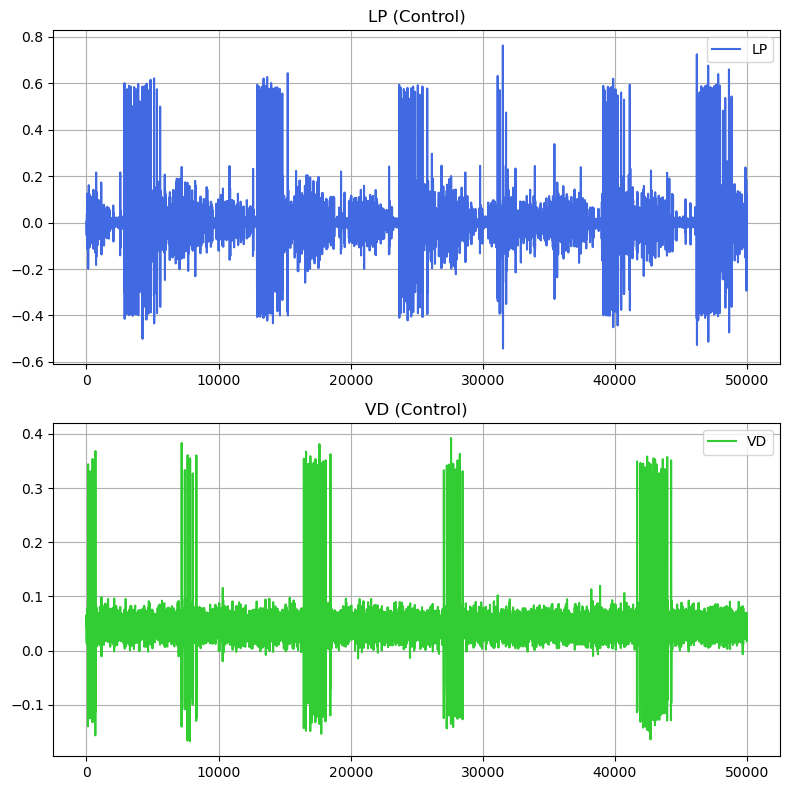

In [6]:
timelim = 50000
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(trozoC['LP'].head(timelim), label='LP', color='royalblue')
axs[0].set_title('LP (Control)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(trozoC['VD'].head(timelim), label='VD', color='limegreen')
axs[1].set_title('VD (Control)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

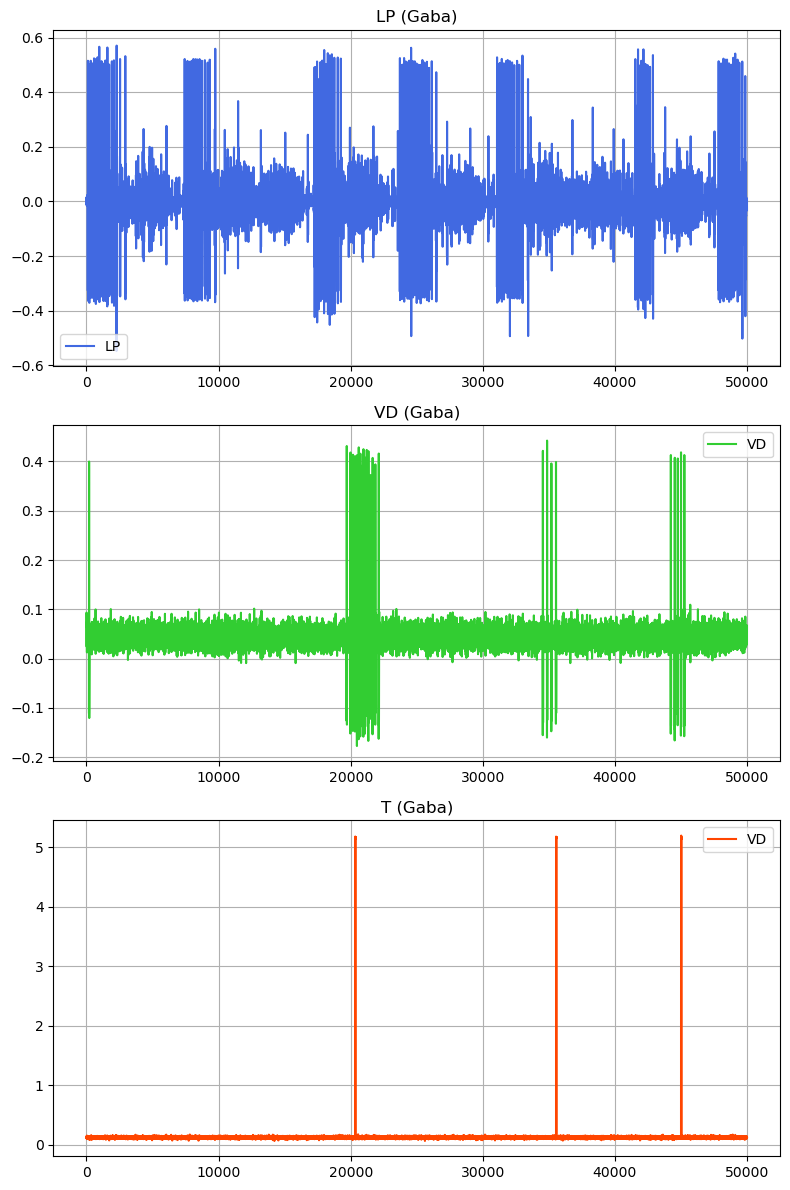

In [7]:
timelim = 50000
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].plot(trozoG['LP'].head(timelim), label='LP', color='royalblue')
axs[0].set_title('LP (Gaba)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(trozoG['VD'].head(timelim), label='VD', color='limegreen')
axs[1].set_title('VD (Gaba)')
axs[1].legend()
axs[1].grid(True)


axs[2].plot(trozoG['T'].head(timelim), label='VD', color='orangered')
axs[2].set_title('T (Gaba)')
axs[2].legend()
axs[2].grid(True)


plt.tight_layout()
plt.show()

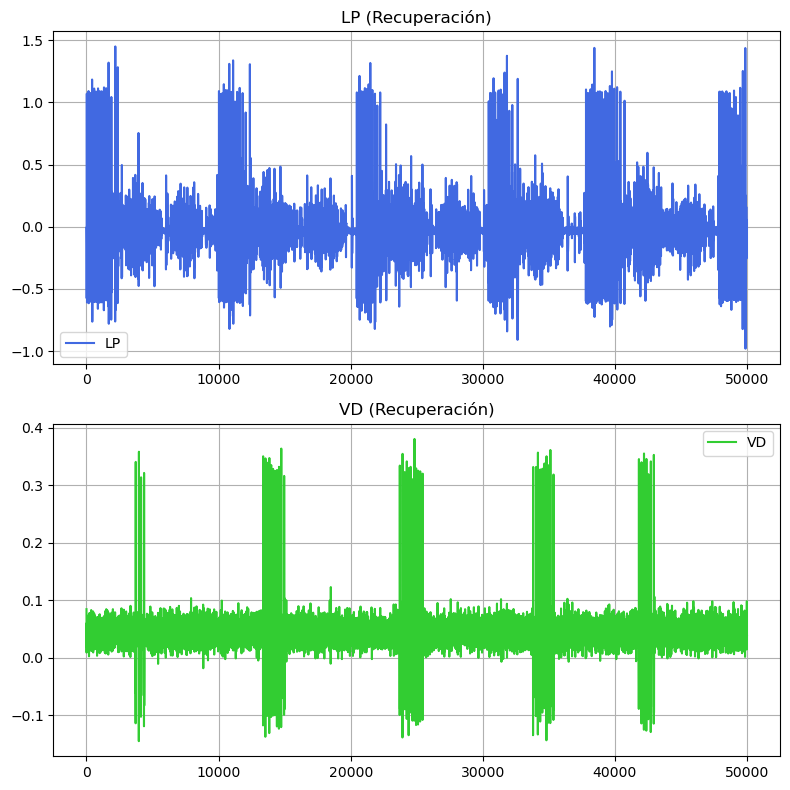

In [8]:
timelim = 50000
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(trozoR['LP'].head(timelim), label='LP', color='royalblue')
axs[0].set_title('LP (Recuperación)')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(trozoR['VD'].head(timelim), label='VD', color='limegreen')
axs[1].set_title('VD (Recuperación)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

Nuestro objetivo es el de, a partir de estos datos recogidos en el laboratorio, transformarlo en una booleana pasándolo a formato de ceros y unos. Haremos corresponder un 1 a la presencia de un spike en la señal o un 0 en ausencia de este. Para ello escogemos un umbral a partir de cual una señal de mayor magnitud que nuestro umbral será considerada como un spike. Asignaremos un 1 al punto en el cual se produce la señal más alta del spike y 0 al resto de puntos. Esto lo hacemos mediante una función de scipi llamada find_peaks, la cual encuentra los picos por encima de un cierto umbral. Esto podemos hacerlo porque nuestros spikes tienen un "buen" comportamiento para nuestra función, ya que en todos los spikes, al cruzar el umbral, la señal aumenta monótonamente hasta alcanzar el pico, tras el cual decrece (tambien monótonamente) hasta bajar del umbral de nuevo. De esta forma, como cada spike presenta un único pico, estamos seguros de que el número de spikes se corresponde con el de picos. Esto puede verse en la siguiente figura.

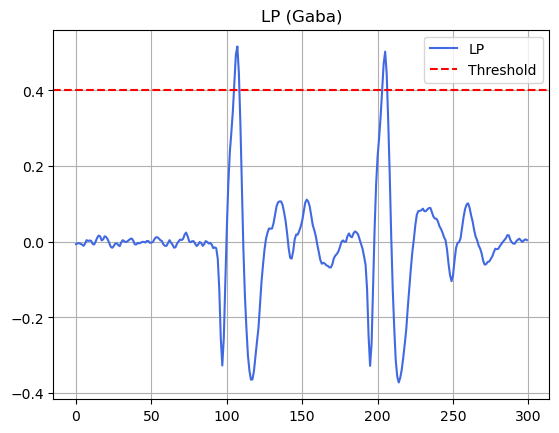

In [9]:
plt.plot(trozoG['LP'].head(300), label='LP', color='royalblue')
plt.axhline(y=0.4, color='red', linestyle='--', label='Threshold')
plt.title('LP (Gaba)')
plt.legend()
plt.grid(True)
plt.show()

Ahora convertimos la señal en la booleana

In [10]:
umbralLPC = 0.4
umbralVDC = 0.25
umbralLPG = 0.4
umbralVDG = 0.25
umbralTG = 3.0
umbralLPR = 0.75
umbralVDR = 0.25

def boolean(trozo, col):

    if trozo == 'trozoC':
        if col == 'LP':
            umbral = umbralLPC
            data = trozoC['LP']
        if col == 'VD':
            umbral = umbralVDC
            data = trozoC['VD']
    if trozo == 'trozoG':
        if col == 'LP':
            umbral = umbralLPG
            data = trozoG['LP']
        if col == 'VD':
            umbral = umbralVDG
            data = trozoG['VD']
        if col == 'T':
            umbral = umbralTG
            data = trozoG['T']
    if trozo == 'trozoR':
        if col == 'LP':
            umbral = umbralLPR
            data = trozoR['LP']
        if col == 'VD':
            umbral = umbralVDR
            data = trozoR['VD']

    aux, _ = scipy.signal.find_peaks(data, height = umbral)
    output = np.zeros(len(data))
    output[aux] = 1
    return output


In [11]:
SLPC = boolean('trozoC', 'LP')
SVDC = boolean('trozoC', 'VD')
SLPG = boolean('trozoG', 'LP')
SVDG = boolean('trozoG', 'VD')
STG = boolean('trozoG', 'T')
SLPR = boolean('trozoR', 'LP')
SVDR = boolean('trozoR', 'VD')

Representamos la transformación en ceros y unos dato a dato

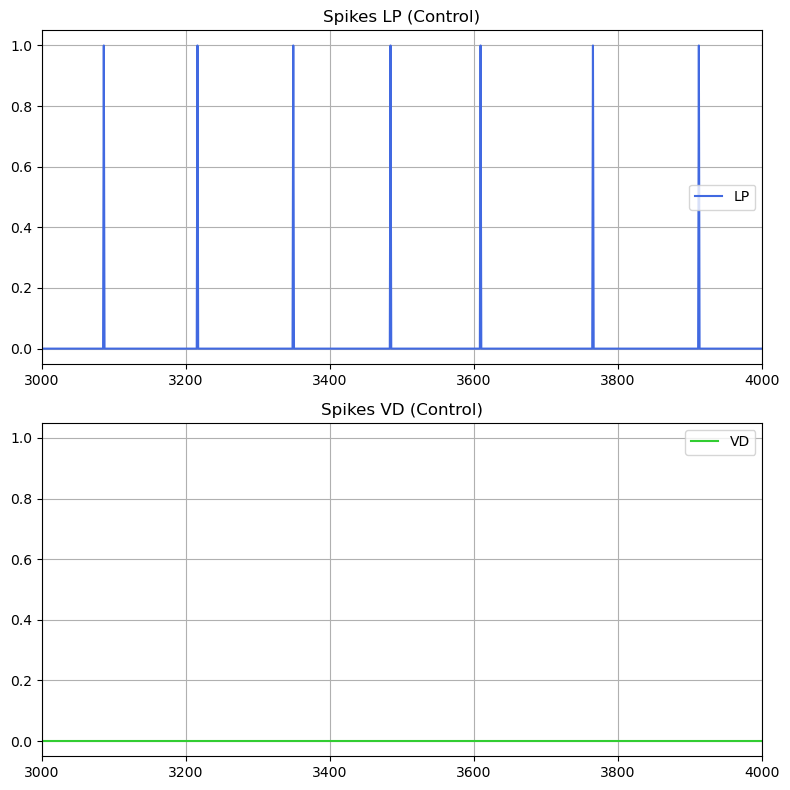

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(SLPC[:timelim], label='LP', color='royalblue')
axs[0].set_title('Spikes LP (Control)')
axs[0].legend()
axs[0].set_xlim([3000, 4000])
axs[0].grid(True)


axs[1].plot(SVDC[:timelim], label='VD', color='limegreen')
axs[1].set_title('Spikes VD (Control)')
axs[1].legend()
axs[1].set_xlim([3000, 4000])
axs[1].grid(True)



plt.tight_layout()
plt.show()

In [13]:
def distancias(booleana):
    indices_1 = np.where(booleana)[0]
    distancias = np.diff(indices_1)
    return distancias

distLPC = distancias(SLPC)

Sin embargo, no queremos transformar directamente nuestra señal en ceros y unos mirando a cada uno de los datos recogidos. Queremos establecer una ventana de tiempo que utilizaremos para contabilizar el número de spikes. Si en esa ventana de tiempo existe algún dato por encima de cierto umbral consideraremos un spike.

In [14]:
# Creamos una función que calcule los spikes en función del tamaño de ventana
# trozo = 'trozoC', 'trozoG', 'trozoR'
# columna = 'LP', 'VD', 'T'
# venana = intervalo de tiempo dado en ms

def señalporventana(data,ventana):

    # Crear un vector de tiempo
    tiempo = np.arange(0,len(data),ventana, dtype=int)

    # Crear una salida para el tiempo y la señal inicializado con ceros
    output = np.zeros((len(tiempo),2))
    output[:,0] = tiempo + ventana / 2
    
   
    # Iterar sobre el DataFrame
    for i in tiempo:
        if i < len(data):
            # Obtener el rango de índices para el intervalo de tiempo actual
            rango_indices = range(i, min(i + int(ventana), len(data)))
            # Verificar si algún valor en el intervalo es mayor que 1.5
            if any(data[rango_indices] == 1):
                output[int(i/int(ventana)),1] = 1
    return output

In [15]:
SLPC10 = señalporventana(SLPC,10)
SLPC50 = señalporventana(SLPC,50)
SLPC100 = señalporventana(SLPC,100)

In [18]:
SVDC10 = señalporventana(SVDC,10)
SVDC50 = señalporventana(SVDC,50)
SVDC100 = señalporventana(SVDC,100)

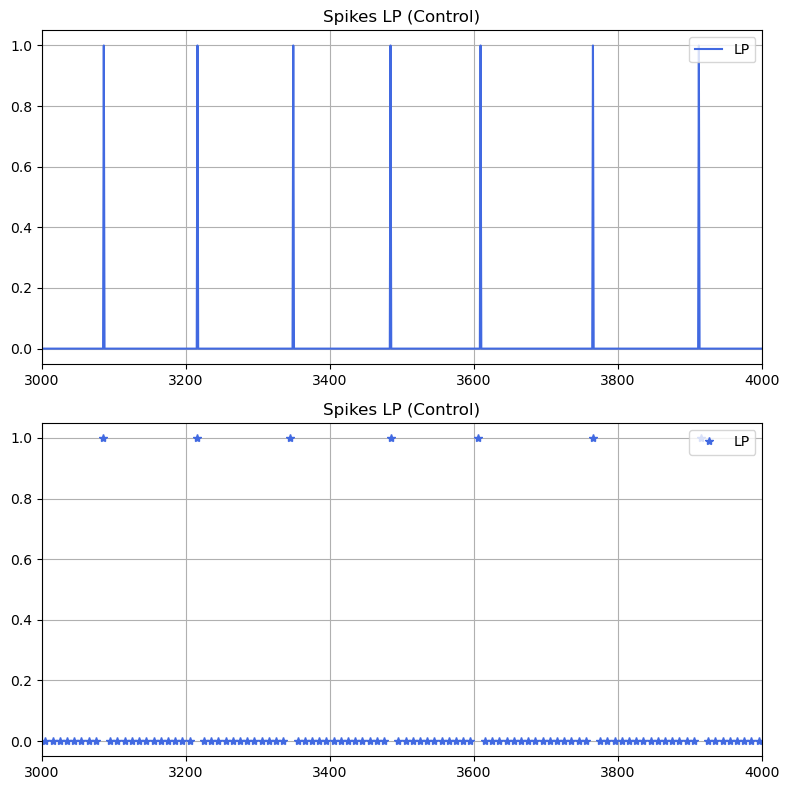

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(SLPC, label='LP', color='royalblue')
axs[0].set_title('Spikes LP (Control)')
axs[0].legend(loc='upper right')
axs[0].set_xlim([3000, 4000])
axs[0].grid(True)


axs[1].plot(SLPC10[:,0], SLPC10[:,1],'*', label='LP', color='royalblue')
axs[1].set_title('Spikes LP (Control)')
axs[1].legend(loc='upper right')
axs[1].set_xlim([3000, 4000])
axs[1].grid(True)



plt.tight_layout()
plt.show()

Representamos la booleana obtenida para el trozo de Control con una ventana de 100 ms

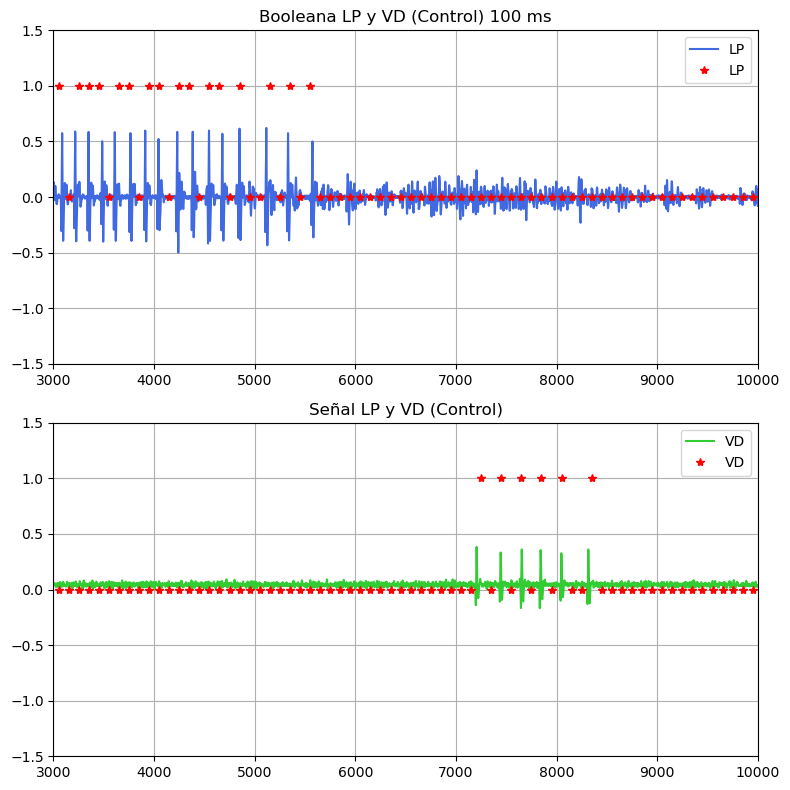

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(trozoC['LP'], label='LP', color='royalblue')
axs[0].plot(SLPC100[:,0], SLPC100[:,1],'*', label='LP', color='red')
axs[0].set_title('Booleana LP y VD (Control) 100 ms')
axs[0].legend(loc="upper right")
axs[0].set_xlim([3000, 10000])
axs[0].set_ylim([-1.5, 1.5])
axs[0].grid(True)

axs[1].plot(trozoC['VD'], label='VD', color='limegreen')
axs[1].plot(SVDC100[:,0], SVDC100[:,1],'*', label='VD', color='red')
axs[1].set_title('Señal LP y VD (Control)')
axs[1].legend(loc="upper right")
axs[1].set_xlim([3000, 10000])
axs[1].set_ylim([-1.5, 1.5])
axs[1].grid(True)

plt.tight_layout()
plt.show()



A fin de determinar cual es la ventana de tiempo óptima vamos a calcular cual es la separación media entre los spikes de la neurona LP (Control).

In [21]:
print('distancia mínima:',np.min(distLPC))
print('distancia máxima:',np.max(distLPC))
np.unique(distLPC, return_counts=True)


distancia mínima: 4
distancia máxima: 22754


(array([    4,     5,    24, ..., 21177, 22323, 22754], dtype=int64),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int64))

Realmente los spikes que tienen una separación de 4 o numeros tan bajos (outliers). Nos interesa cual es la distancia real entre distintos spikes.

[ 97 111 130 ... 171 178 359]


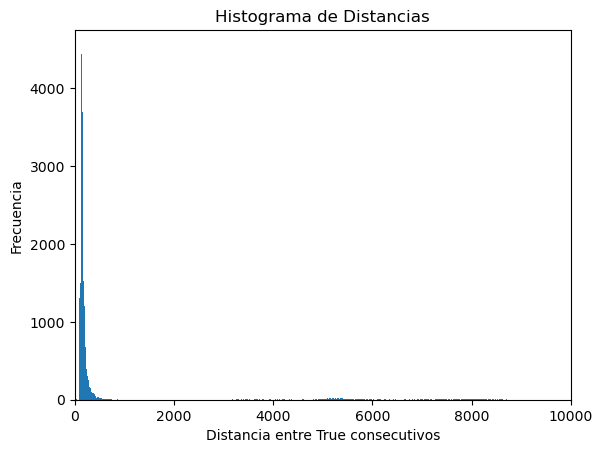

(array([    4,     5,    24, ..., 21177, 22323, 22754], dtype=int64), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
distancia más frecuente:


In [22]:
#distancias = distancias[distancias < 15000]
print(distLPC)
plt.hist(distLPC, bins=2000)
plt.xlabel('Distancia entre True consecutivos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Distancias')
plt.xlim([0,10000])
plt.show()
print(np.unique(distLPC,return_counts=True))
print('distancia más frecuente:')

[ 97 111 130 ... 171 178 359]


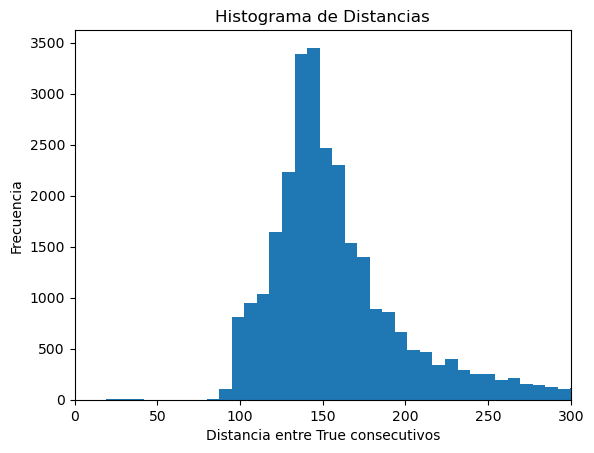

(array([    4,     5,    24, ..., 21177, 22323, 22754], dtype=int64), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
distancia más frecuente:


In [23]:
print(distLPC)
plt.hist(distLPC, bins=3000)
plt.xlabel('Distancia entre True consecutivos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Distancias')
plt.xlim([0,300])
plt.show()
print(np.unique(distLPC,return_counts=True))
print('distancia más frecuente:')

Vemos que la separación entre spikes comienza a ser frecuente a partir de en torno a 80 ms. Por tanto, parece buena idea escoger un intervalo de tiempo lo más grande posible pero que minimice los errores de recoger dos spikes como uno solo. Esto nos los podemos asegurar cogiendo como intervalo un número menor a las distancias mínimas más comunes en el histograma.

Comparamos los resultados de la señal con las diferentes ventanas. Lo ahcemos tanto en número de spikes como de forma gráfica.

31074.0 spikes
31073.0 spikes con ventana de 10 ms, perdidos: 0.003218124477055717 %
31061.0 spikes con ventana de 50 ms, perdidos: 0.04183561820171322 %
31044.0 spikes con ventana de 100 ms, perdidos: 0.09654373431163821 %


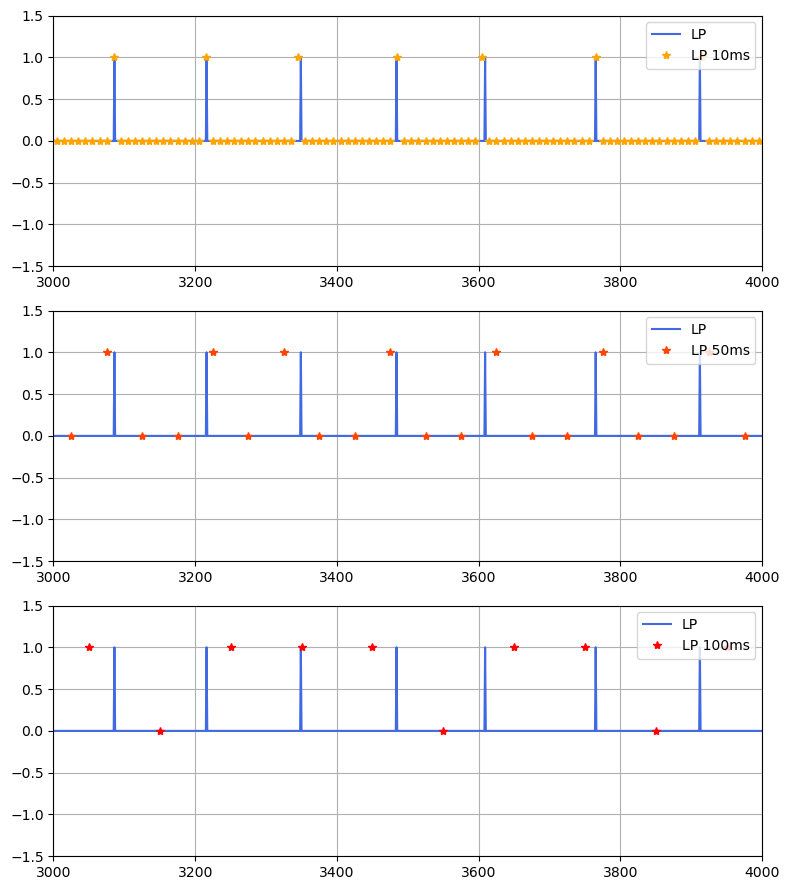

In [24]:
print(SLPC.sum(),'spikes')
print(SLPC10[:,1].sum(),'spikes con ventana de 10 ms, perdidos:', 100*(1-SLPC10[:,1].sum()/SLPC.sum()),'%')
print(SPC50[:,1].sum(),'spikes con ventana de 50 ms, perdidos:', 100*(1-SLPC50[:,1].sum()/SLPC.sum()),'%')
print(SLPC100[:,1].sum(),'spikes con ventana de 100 ms, perdidos:', 100*(1-SLPC100[:,1].sum()/SLPC.sum()),'%')

fig, axs = plt.subplots(3, 1, figsize=(8, 9))

axs[0].plot(SLPC,label='LP',color='royalblue')
axs[0].plot(SLPC10[:10000,0], SLPC10[:10000,1],'*',label='LP 10ms',color='orange')
axs[0].legend(loc="upper right")
axs[0].set_xlim([3000, 4000])
axs[0].set_ylim([-1.5, 1.5])
axs[0].grid(True)

axs[1].plot(SLPC,label='LP',color='royalblue')
axs[1].plot(SLPC50[:10000,0], SLPC50[:10000,1],'*',label='LP 50ms',color='orangered')
axs[1].legend(loc="upper right")
axs[1].set_xlim([3000, 4000])
axs[1].set_ylim([-1.5, 1.5])
axs[1].grid(True)

axs[2].plot(SLPC,label='LP',color='royalblue')
axs[2].plot(SLPC100[:10000,0], SLPC100[:10000,1],'*',label='LP 100ms',color='red')
axs[2].legend(loc="upper right")
axs[2].set_xlim([3000, 4000])
axs[2].set_ylim([-1.5, 1.5])
axs[2].grid(True)


plt.tight_layout()
plt.show()

22149.0 spikes
22148.0 spikes con ventana de 10 ms, perdidos: 0.004514876518124655
22139.0 spikes con ventana de 50 ms, perdidos: 0.04514876518126876
21863.0 spikes con ventana de 100 ms, perdidos: 1.2912546841843842


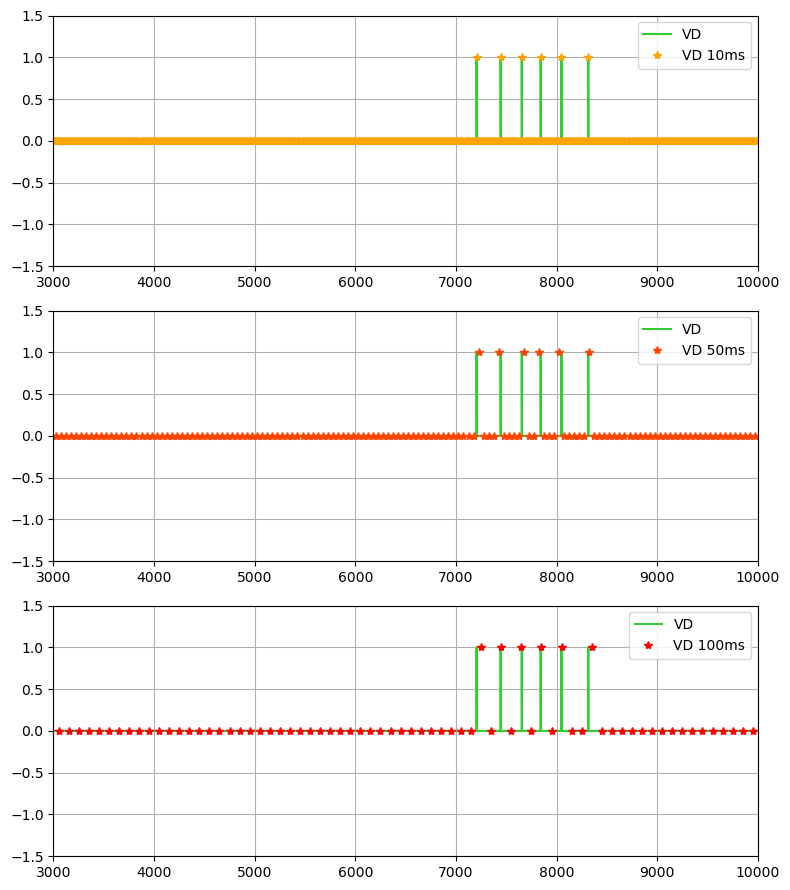

In [25]:
print(SVDC.sum(),'spikes')
print(SVDC10[:,1].sum(),'spikes con ventana de 10 ms, perdidos:', 100*(1-SVDC10[:,1].sum()/SVDC.sum()))
print(SVDC50[:,1].sum(),'spikes con ventana de 50 ms, perdidos:', 100*(1-SVDC50[:,1].sum()/SVDC.sum()))
print(SVDC100[:,1].sum(),'spikes con ventana de 100 ms, perdidos:', 100*(1-SVDC100[:,1].sum()/SVDC.sum()))

fig, axs = plt.subplots(3, 1, figsize=(8, 9))

axs[0].plot(SVDC,label='VD',color='limegreen')
axs[0].plot(SVDC10[:10000,0], SVDC10[:10000,1],'*',label='VD 10ms',color='orange')
axs[0].legend(loc="upper right")
axs[0].set_xlim([3000, 10000])
axs[0].set_ylim([-1.5, 1.5])
axs[0].grid(True)

axs[1].plot(SVDC,label='VD',color='limegreen')
axs[1].plot(SVDC50[:10000,0], SVDC50[:10000,1],'*',label='VD 50ms',color='orangered')
axs[1].legend(loc="upper right")
axs[1].set_xlim([3000, 10000])
axs[1].set_ylim([-1.5, 1.5])
axs[1].grid(True)

axs[2].plot(SVDC,label='VD',color='limegreen')
axs[2].plot(SVDC100[:10000,0], SVDC100[:10000,1],'*',label='VD 100ms',color='red')
axs[2].legend(loc="upper right")
axs[2].set_xlim([3000, 10000])
axs[2].set_ylim([-1.5, 1.5])
axs[2].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
ventanas = [70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
spikeperdidasLPC = np.zeros((len(ventanas),2))
spikeperdidasVDC = np.zeros((len(ventanas),2))
spikeperdidasLPG = np.zeros((len(ventanas),2))
spikeperdidasVDG = np.zeros((len(ventanas),2))
spikeperdidasLPR = np.zeros((len(ventanas),2))
spikeperdidasVDR = np.zeros((len(ventanas),2))


for i in range(len(ventanas)): 
    auxLPC = señalporventana(SLPC,ventanas[i])
    auxVDC = señalporventana(SVDC,ventanas[i])
    auxLPG = señalporventana(SLPG,ventanas[i])
    auxVDG = señalporventana(SVDG,ventanas[i])
    auxLPR = señalporventana(SLPR,ventanas[i])
    auxVDR = señalporventana(SVDR,ventanas[i])

    spikeperdidasLPC[i,0] = ventanas[i]
    spikeperdidasVDC[i,0] = ventanas[i]
    spikeperdidasLPG[i,0] = ventanas[i]
    spikeperdidasVDG[i,0] = ventanas[i]
    spikeperdidasLPR[i,0] = ventanas[i]
    spikeperdidasVDR[i,0] = ventanas[i]

    spikeperdidasLPC[i,1] = 100*(1-auxLPC[:,1].sum()/SLPC.sum())
    spikeperdidasVDC[i,1] = 100*(1-auxVDC[:,1].sum()/SVDC.sum())
    spikeperdidasLPG[i,1] = 100*(1-auxLPG[:,1].sum()/SLPG.sum())
    spikeperdidasVDG[i,1] = 100*(1-auxVDG[:,1].sum()/SVDG.sum())
    spikeperdidasLPR[i,1] = 100*(1-auxLPR[:,1].sum()/SLPR.sum())
    spikeperdidasVDR[i,1] = 100*(1-auxVDR[:,1].sum()/SVDR.sum())

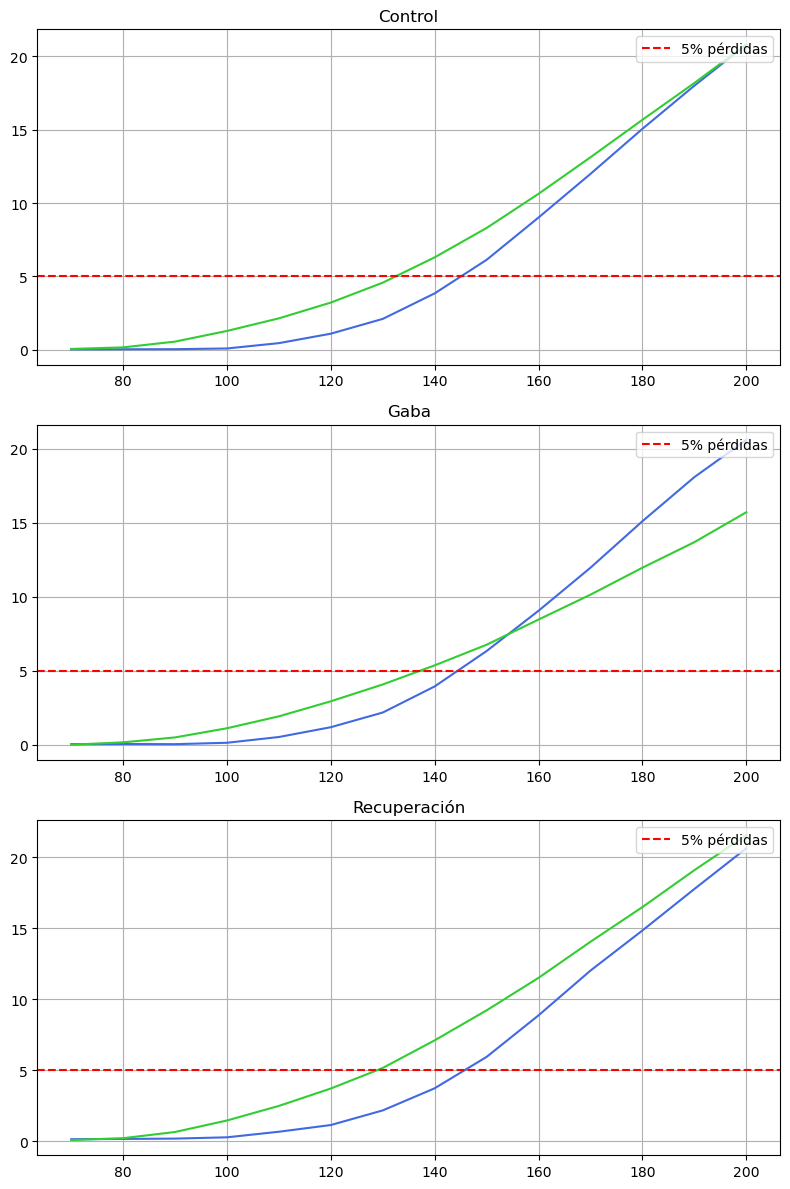

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].plot(spikeperdidasLPC[:,0], spikeperdidasLPC[:,1], color = 'royalblue')
axs[0].plot(spikeperdidasVDC[:,0], spikeperdidasVDC[:,1], color = 'limegreen')
axs[0].axhline(y=5, color='red', linestyle='--', label='5% pérdidas')
axs[0].set_title('Control')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].plot(spikeperdidasLPG[:,0], spikeperdidasLPG[:,1], color = 'royalblue')
axs[1].plot(spikeperdidasVDG[:,0], spikeperdidasVDG[:,1], color = 'limegreen')
axs[1].axhline(y=5, color='red', linestyle='--', label='5% pérdidas')
axs[1].set_title('Gaba')
axs[1].legend(loc='upper right')
axs[1].grid(True)

axs[2].plot(spikeperdidasLPR[:,0], spikeperdidasLPR[:,1], color = 'royalblue')
axs[2].plot(spikeperdidasVDR[:,0], spikeperdidasVDR[:,1], color = 'limegreen')
axs[2].axhline(y=5, color='red', linestyle='--', label='5% pérdidas')
axs[2].set_title('Recuperación')
axs[2].legend(loc='upper right')
axs[2].grid(True)

plt.tight_layout()
plt.show()

Ahora queremos almacenar las palabras de información 

2 bit

In [29]:

SLPC120 = señalporventana(SLPC,120)
SVDC120 = señalporventana(SVDC,120)
SLPG120 = señalporventana(SLPG,120)
SVDG120 = señalporventana(SVDG,120)
STG120 = señalporventana(STG,120)
SLPR120 = señalporventana(SLPR,120)
SVDR120 = señalporventana(SVDR,120)


In [61]:
# Esta función calcula las palabras dada un señal y el número de palabras 
# señal: array unidimensional del que queremos obtener las palabras 
# nbits: número de bits para las palabras 
# retorna como output un array donde cada elemento es la palabras de nbits bits 
# en cada palabras se encuentran el valor de la señal en esa posición y las nbits-1 siguientes
def words(señal,nbits):
    array = np.zeros((len(señal)-nbits+1,nbits))

    for i in range(0,len(señal)-nbits+1):
        for j in range(nbits):
            array[i,j] = señal[i+j]
    return array


In [81]:
# Calculamos todas las palabras de todas las señales con ventana de 120
# Creamos un diccionario para almacenar las variables
# (7s)
SLPC120_names = {}
SVDC120_names = {}
SLPG120_names = {}
SVDG120_names = {}
STG120_names = {}
SLPR120_names = {}
SVDR120_names = {}
# Sacamos las palabras para la LPC120
# Tarda solo 1s
for nbits in np.arange(1, 8 + 1):
    LPC_name = f"SLPC120_{nbits}"
    VDC_name = f"SVDC120_{nbits}"
    LPG_name = f"SLPG120_{nbits}"
    VDG_name = f"SVDG120_{nbits}"
    TG_name = f"STG120_{nbits}"
    LPR_name = f"SLPR120_{nbits}"   
    VDR_name = f"SVDR120_{nbits}"

    SLPC120_names[LPC_name] = words(señalLPC120[:, 1],nbits)
    SVDC120_names[VDC_name] = words(señalVDC120[:, 1],nbits)
    SLPG120_names[LPG_name] = words(señalLPG120[:, 1],nbits)
    SVDG120_names[VDG_name] = words(señalVDG120[:, 1],nbits)
    STG120_names[TG_name] = words(señalTG120[:, 1],nbits)
    SLPR120_names[LPR_name] = words(señalLPR120[:, 1],nbits)
    SVDR120_names[VDR_name] = words(señalVDR120[:, 1],nbits)

165398
165397
165396
165395
165394
165393
165392
165391


In [ ]:
print